# SVD basic

Idea: Assume the data has an underlying structure where each user and each item has a representation in the same concept space. Can use baseline solution (approximated matrix X_init, where missing ratings are set to average of user's available ratings) as an initialization for SVD. By discarding small singular values we can remove noise and approximate X_true. 

In [8]:
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from matrix_helpers import load_data, write_submission_file

## Load training data

In [2]:
# build the rating matrix from the training data set(available ratings), entries for unvailable ratings are set to 0
X = load_data()
print(X[0:10,0:10])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 5.]
 [0. 0. 0. 3. 0. 5. 0. 4. 0. 0.]
 [0. 0. 0. 2. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0. 5. 0. 3. 0. 0.]
 [0. 0. 0. 0. 0. 5. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 5. 0. 0. 0. 3.]
 [0. 0. 0. 1. 0. 5. 0. 5. 0. 0.]]


## Predict missing ratings with average ratings per user

In [3]:
# calcualte a vector which contains the means of the available ratings of each user
y = X.sum(axis=1)
rating_counts = np.count_nonzero(X, axis =1)
average_per_user = y/rating_counts
X_init = np.copy(X)
for row in range(X.shape[0]):
    # entries for unavailable ratings were set to 0 at time when the rating matrix was built
    no_rating = (X[row, :] == 0)
    # for each user, set all the missing ratings to the average of this users available ratings
    X_init[row, no_rating] = average_per_user[row]
print(X_init[0:10, 0:10])


[[4.04347826 4.04347826 4.04347826 4.04347826 4.04347826 4.04347826
  4.04347826 4.04347826 4.04347826 5.        ]
 [3.77181208 3.77181208 3.77181208 3.         3.77181208 5.
  3.77181208 4.         3.77181208 3.77181208]
 [3.52325581 3.52325581 3.52325581 2.         3.52325581 3.52325581
  3.52325581 3.52325581 3.52325581 3.52325581]
 [3.8        3.8        3.8        3.8        3.8        3.8
  3.8        3.8        3.8        3.8       ]
 [3.98507463 2.         3.98507463 3.98507463 3.98507463 5.
  3.98507463 3.         3.98507463 3.98507463]
 [4.36686391 4.36686391 4.36686391 4.36686391 4.36686391 5.
  4.36686391 4.36686391 4.36686391 4.36686391]
 [4.12903226 4.12903226 4.12903226 4.12903226 4.12903226 4.12903226
  4.12903226 4.12903226 4.12903226 4.12903226]
 [4.11538462 4.11538462 4.11538462 4.11538462 4.11538462 4.11538462
  4.11538462 4.11538462 4.11538462 4.11538462]
 [3.97191011 3.97191011 3.97191011 3.97191011 3.97191011 5.
  3.97191011 3.97191011 3.97191011 3.        ]
 [3.

## Singular Value Decomposition

In [4]:
# do a svd of the X_init matrix built above
U, d, Vt = np.linalg.svd(X_init, full_matrices=True)
print(U.shape)
print(d.shape)
print(Vt.shape)
# create a diagonal matrix from the vector d of the SVD
D = np.zeros_like(X_init)
D[:d.shape[0], :d.shape[0]] = np.diag(d)

(10000, 10000)
(1000,)
(1000, 1000)


In [5]:
# assure equality (within a tolerance of U* D * Vt and X_init)
assert np.allclose(np.dot(U, np.dot(D, Vt)), X_init)

[12150.99490984   150.1691806     98.39707914    82.98542208
    79.86171735    79.68578868    77.19077004    74.0177768
    72.25882996    71.16727918    70.57179145    69.90965182
    69.12010718    68.98402185    68.32132001    68.18400344
    67.71638283    67.51535179    66.64476926    66.16722878
    65.95780317    65.32226758    65.14423775    64.72297138
    64.58497676    64.40576522    64.02703284    63.82955763
    63.54102938    63.4629603     63.14573785    63.04975588
    62.68436699    62.3787418     62.33113844    62.12670405
    61.96315305    61.76188451    61.74365357    61.61284288
    61.42090559    61.38553394    61.11665547    61.0696715
    60.88483477    60.83545683    60.56002967    60.37644524
    60.23462486    60.10575168    59.98494211    59.89308451
    59.75341423    59.56386867    59.3855731     59.3310651
    59.13393078    59.07160039    58.92395991    58.90812156
    58.87989116    58.69594018    58.60372472    58.52507677
    58.31078247    58.10291

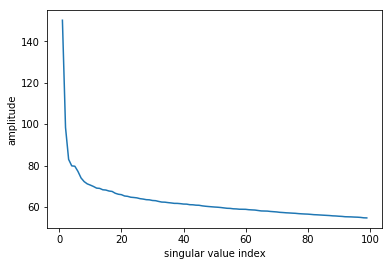

In [6]:
# plot singular values
k_plot = 100
singular_range = range(1,k_plot,1)
plt.plot(singular_range, d[1:k_plot]) # skip frist singular value for better visualization
plt.xlabel("singular value index")
plt.ylabel("amplitude")
print(d[:100])

In [7]:
# Reconstruct Matrix -> Approximation by removing small singular values
k = 15
# extract the submatrices from U,D and Vt
U_prime = U[:,:k]
D_prime = D[:k, :k]
Vt_prime = Vt[:k, :]
# reconstruct the matrix ba multiplying back together the single matrices
X_pred = np.dot(U_prime, np.dot(D_prime, Vt_prime))
assert X_init.shape == X_pred.shape

## Output submission file 

In [ ]:
# write the predicted ratings back to a csv file
output = write_submission_file(X_pred, "submission_SVD_basic_1.csv")
print(output[0:100])